# Analyze zoning districts and minimum lot sizes

In [1]:
from sqlalchemy import create_engine
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DB = create_engine('postgresql://jon@localhost:5432/propertydb')

In [3]:
ZONES = pd.DataFrame([
    ['R1D-VL', 8000, 'SINGLE|TOWNHOUSE|ROWHOUSE'],
    ['R1D-L', 5000, 'SINGLE|TOWNHOUSE|ROWHOUSE'],
    ['R1D-M', 3200, 'SINGLE|TOWNHOUSE|ROWHOUSE'], # 'R1A-M'
    ['R1D-H', 1800, 'SINGLE|TOWNHOUSE|ROWHOUSE'], # 'R1A-H'
    ['R1D-VH', 1200, 'SINGLE|TOWNHOUSE|ROWHOUSE'], # 'R1A-VH'
    ['RM-VL', 8000*4, 'APART|FOUR'],
    ['RM-L', 3000*4, 'APART|FOUR'],
    ['RM-M', 1800*4, 'APART|FOUR'],
    ['RM-H', 750*4, 'APART|FOUR'],
    ['RM-VH', 400*4, 'APART|FOUR']
], columns=['zon_new', 'minlot4construction', 'usedesc'])

In [4]:
def gen_lot_size_data(zones, nabename = None):
    zones_info = ZONES[ZONES.zon_new == zones[0]]

    zones_parcels = parcels
    if nabename is None:
        zones_parcels = parcels[parcels.zon_new.isin(zones)]
    else:
        zones_parcels = parcels[(parcels.zon_new.isin(zones)) & (parcels.nabename.isin(nabename))]

    return [
        zones_parcels,
        zones_parcels[zones_parcels.usedesc.str.contains(zones_info.usedesc.values[0])], # zones_parcels_constructed
        zones_info.minlot4construction.values[0] # zones_parcels_min
    ]

def gen_lot_size_hist(zones):
    zon_new_parcels, zon_new_parcels_constructed, zon_new_parcels_min = gen_lot_size_data(zones)

    # Print quick stats
    zon_new_parcels_below_len = len(zon_new_parcels[zon_new_parcels.lotarea < zon_new_parcels_min])
    zon_new_parcels_len = len(zon_new_parcels)

    print('Below: %s (%s)' % (zon_new_parcels_below_len, round(zon_new_parcels_below_len / zon_new_parcels_len, 2)))
    print('At/above: %s (%s)' % (zon_new_parcels_len - zon_new_parcels_below_len, round((zon_new_parcels_len - zon_new_parcels_below_len) / zon_new_parcels_len, 2)))

    # Sketch the plot
    fig, ax = plt.subplots()
    ax.hist([
        zon_new_parcels.lotarea.values.flatten(),
        zon_new_parcels_constructed.lotarea.values.flatten()
    ], bins=30, range=(0, 30000), label=['Parcels', 'Parcels constructed'])

    # zon_new_parcels.plot(kind='hist', column='lotarea', bins=30, range=(400, 30000), label='Parcels')
    # zon_new_parcels[zon_new_parcels.usedesc.str.contains('APART')].plot(kind='hist', column='lotarea', bins=30, range=(400, 30000), label='Apts')

    plt.title("%s MLS (%s sqft)" % (', '.join(zones), zon_new_parcels_min))

    plt.axvline(zon_new_parcels_min, label='MLS for construction', color='red', linestyle='dashed', alpha=0.2)
    plt.axvspan(0, zon_new_parcels_min, label='Parcels below MLS for construction', color='red', alpha=0.2)
    plt.axvline(zon_new_parcels_constructed.lotarea.min(), label='Smallest parcel constructed', color='green', linestyle='dashed', alpha=0.2)
    plt.legend()
    return plt

### Import RM, R1 parcels

In [5]:
parcels = gpd.read_postgis("""SELECT assessments.*, nabename, zon_new, parcelboundaries.geom
FROM assessments
JOIN parcelboundaries
ON parcelboundaries.parcelid = assessments.parcelid
JOIN parcelzoningpgh
ON ST_WITHIN(parcelboundaries.geom, parcelzoningpgh.geom)
JOIN neighborhoodpgh
ON ST_WITHIN(parcelboundaries.geom, neighborhoodpgh.geom)
WHERE municode::int < 200
AND lotarea::int > 0
AND LEFT(zon_new, 2) IN ('RM', 'R1')
AND usedesc NOT IN ('CONDOMINIUM', 'CONDO DEVELOPMENTAL LAND', 'CONDO GARAGE UNITS');""", DB, crs='EPSG:4326')

In [6]:
parcels['lotarea'] = parcels.lotarea.astype(int)

### Parcel count by RM density

In [7]:
parcels[parcels.zon_new.str.startswith('RM')].zon_new.value_counts()

zon_new
RM-M     8150
RM-H      227
RM-VH     108
RM-VL       8
Name: count, dtype: int64

### Lot size histograms for RM densities

Below: 7381 (0.91)
At/above: 769 (0.09)


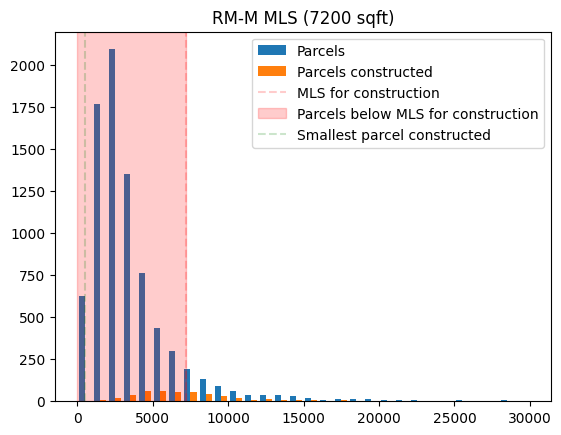

In [8]:
gen_lot_size_hist(['RM-M']).show()

Below: 81 (0.36)
At/above: 146 (0.64)


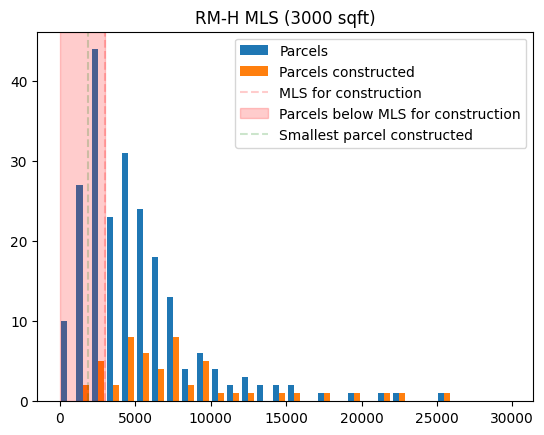

In [9]:
gen_lot_size_hist(['RM-H']).show()

Below: 2 (0.02)
At/above: 106 (0.98)


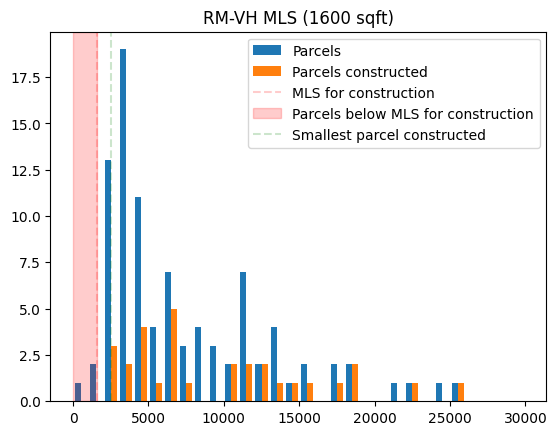

In [10]:
gen_lot_size_hist(['RM-VH']).show()

### Parcel count by R1 density

In [11]:
parcels[parcels.zon_new.str.startswith('R1')].zon_new.value_counts()

zon_new
R1D-H     19244
R1D-L     17897
R1D-M     13676
R1A-VH     9449
R1A-H      7736
R1D-VL     1315
R1A-M       883
R1D-VH       46
Name: count, dtype: int64

### Lot size histograms for R1 densities

Below: 489 (0.37)
At/above: 826 (0.63)


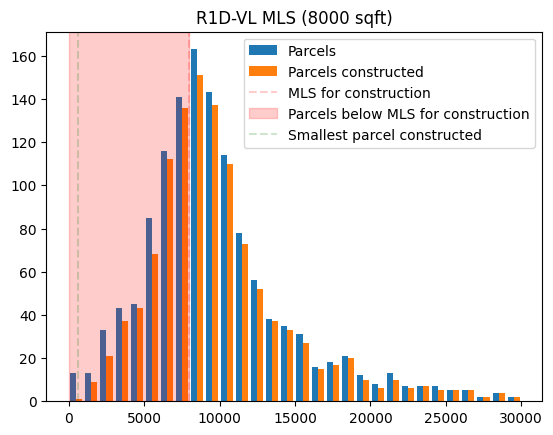

In [12]:
gen_lot_size_hist(['R1D-VL']).show()

Below: 7187 (0.4)
At/above: 10710 (0.6)


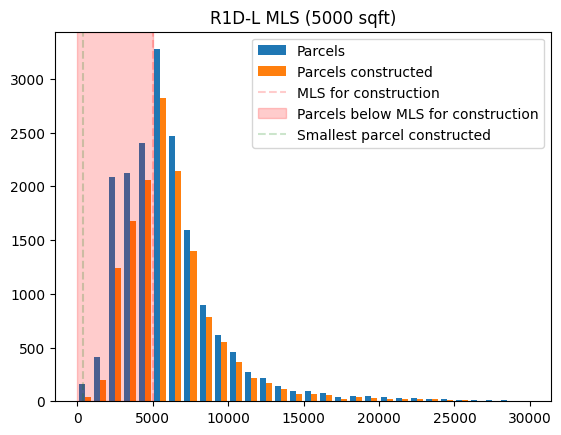

In [13]:
gen_lot_size_hist(['R1D-L']).show()

Below: 3477 (0.24)
At/above: 11082 (0.76)


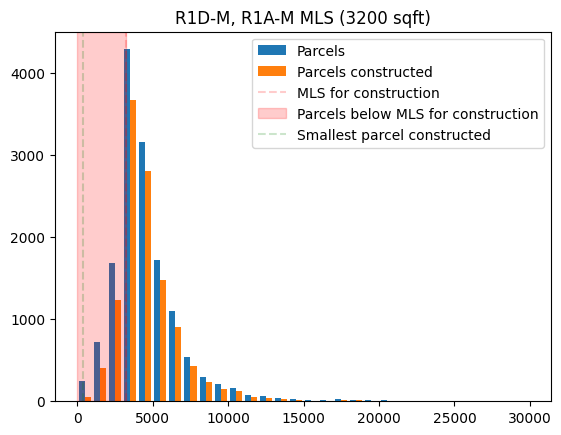

In [14]:
gen_lot_size_hist(['R1D-M', 'R1A-M']).show()

Below: 4373 (0.16)
At/above: 22607 (0.84)


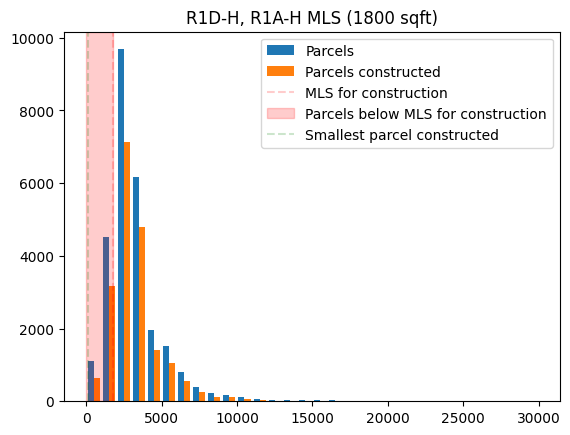

In [15]:
gen_lot_size_hist(['R1D-H', 'R1A-H']).show()

Below: 2788 (0.29)
At/above: 6707 (0.71)


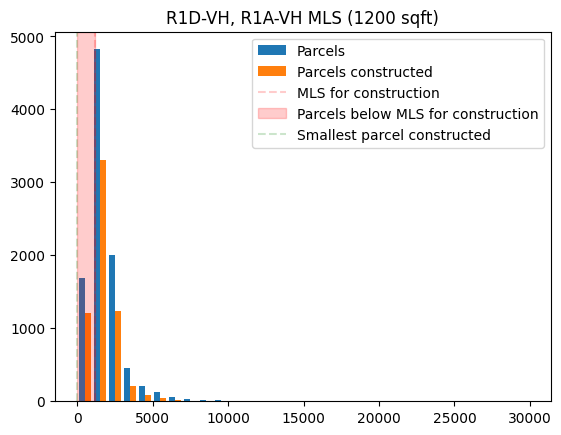

In [16]:
gen_lot_size_hist(['R1D-VH', 'R1A-VH']).show()

### Calculate `RM-M` impact of keeping min lot size, removing per-unit min lot size

In [17]:
rmm = parcels[
    (parcels.zon_new == 'RM-M') &
    (~parcels.usedesc.str.contains('APART|FOUR'))
]

rmm_agg = rmm.groupby('nabename').apply(lambda x: pd.Series(dict(
    lt3200=(x.lotarea < 3200).sum(),
    gte3200=(x.lotarea >= 3200).sum(),
    gte3200lt7200=((x.lotarea >= 3200) & (x.lotarea < 7200)).sum(),
    gte7200=(x.lotarea >= 7200).sum()
)))

rmm_agg['dual_min_lot_req_pct'] = rmm_agg.gte7200 / rmm_agg.gte3200
rmm_agg['gte3200lt7200_4apt'] = rmm_agg.gte3200lt7200 * 4

print([rmm_agg.gte3200lt7200.sum(), rmm_agg.gte3200lt7200_4apt.sum()])
rmm_agg.sort_values(by='gte3200lt7200', ascending=False).head(15)

[2206, 8824]


,lt3200,gte3200,gte3200lt7200,gte7200,dual_min_lot_req_pct,gte3200lt7200_4apt
nabename,,,,,,
Lincoln-Lemington-Belmar,821,522,402,120,0.229885,1608
Squirrel Hill South,317,432,396,36,0.083333,1584
Homewood South,625,416,365,51,0.122596,1460
Middle Hill,1150,270,185,85,0.314815,740
East Hills,184,202,176,26,0.128713,704
Squirrel Hill North,71,138,128,10,0.072464,512
Homewood North,369,116,103,13,0.112069,412
Crawford-Roberts,613,89,68,21,0.235955,272
Shadyside,64,85,62,23,0.270588,248


### Save `RM-M`, Squirrel Hill lot size information

In [18]:
zones_parcels, zones_parcels_constructed, _ = gen_lot_size_data(['RM-M'], ['Squirrel Hill North', 'Squirrel Hill South'])

In [19]:
exportdf = pd.DataFrame(columns=['lotarea', 'lotcount', 'constructedcount'])
for x in range(0, 30000, 1000):
    exportdf.loc[len(exportdf.index)] = [
        x,
        len(zones_parcels[(zones_parcels.lotarea >= x) & (zones_parcels.lotarea < x + 1000)]),
        len(zones_parcels_constructed[(zones_parcels_constructed.lotarea >= x) & (zones_parcels_constructed.lotarea < x + 1000)])
    ]

exportdf.to_csv('../output/zoning-parcels-RMM-sqhill.csv', index=False)